In [8]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.dpi'] = 300

In [9]:
import skimage.io
mask = skimage.io.imread('/Volumes/DataDrive/final_train/5I_crop_ensemble_0_masks.tif')

(-0.5, 599.5, 599.5, -0.5)

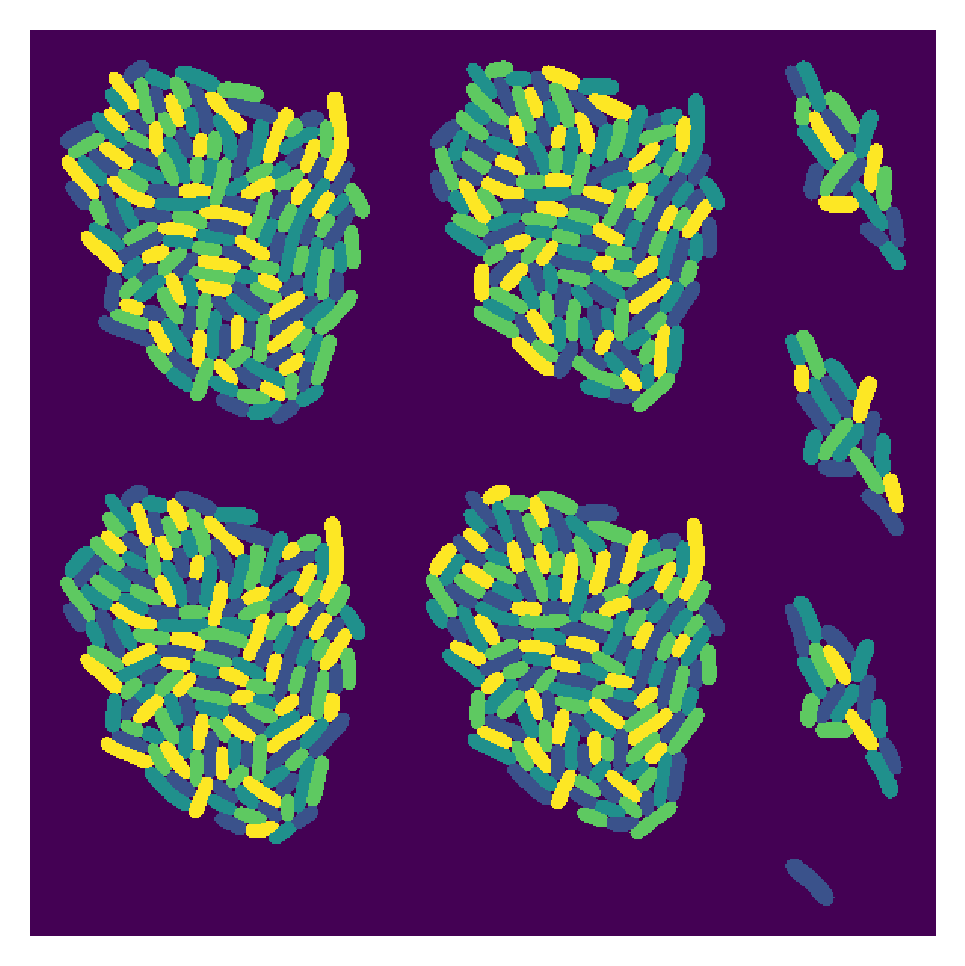

In [18]:
# ncolor.__dict__
import ncolor.ncolor as ncolor
nc = ncolor.label(mask)
plt.imshow(nc,interpolation='None')
plt.axis('off')